# 1. Importing the neccesary libraries and packages

In [1]:
# Import necessary libraries and modules
import numpy as np  # For numerical computations
import os  # For handling directories and file paths
from IPython.display import Image, display  # For displaying images and text
import random  # For generating random numbers
import itertools  # For creating iterator functions
from tabulate import tabulate  # Import tabulate for creating and displaying tabular data
import matplotlib.pyplot as plt  # For plotting and visualizations
%matplotlib inline
import seaborn as sns  # For advanced plotting and visualizations
import pandas as pd  # For handling dataframes
import json  # For handling JSON data

from IPython.display import display  # For displaying objects in Jupyter notebooks
import shutil  # For file operations like moving and copying
from PIL import ImageFile, Image  # For image processing

from tensorflow.keras.layers import Flatten  # For flattening layers in neural networks
from tensorflow.compat.v1 import ConfigProto  # For TensorFlow configuration settings
from tensorflow.compat.v1 import InteractiveSession  # For TensorFlow sessions
from tensorflow.keras.callbacks import ModelCheckpoint  # For saving models during training
from tensorflow.keras import layers, models, optimizers  # For building and optimizing models
from tensorflow.keras.models import Sequential, load_model  # For creating and loading models
from tensorflow.keras.layers import Dense  # For dense layers in neural networks
from keras.preprocessing.image import ImageDataGenerator  # For image data augmentation
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix  # For evaluation metrics
from sklearn.model_selection import StratifiedKFold  # For cross-validation
from tensorflow.keras.applications import InceptionV3  # For using InceptionV3 architecture
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # For image loading and processing

# Importing popular pre-trained models
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19

# 2. Defining the necessary Functions

In [2]:
def transferBetweenFolders(source, dest, splitRate):
    """
    Transfer a specified percentage of files from the source folder to the destination folder.
    
    Parameters:
    source (str): Path of the source folder
    dest (str): Path of the destination folder
    splitRate (float): The percentage of files to transfer, as a decimal between 0 and 1
    """
    
    # Access the global variable sourceFiles
    global sourceFiles
    
    # List all files in the source directory
    sourceFiles = os.listdir(source)
    
    # Check if there are files in the source directory
    if(len(sourceFiles) != 0):
        
        # Calculate the number of files to transfer based on the splitRate
        transferFileNumbers = int(len(sourceFiles) * splitRate)
        
        # Randomly select the indexes of files to transfer
        transferIndex = random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        
        # Move the selected files from the source to the destination folder
        for eachIndex in transferIndex:
            shutil.move(source + str(sourceFiles[eachIndex]), dest + str(sourceFiles[eachIndex]))
            
    else:
        # If the source folder is empty, print an error message
        print("No file moved. Source empty!")

        

def transferAllClassBetweenFolders(source, dest, splitRate):
    """
    Transfer a specified percentage of files from the source folder to the destination folder
    for each class in classLabels.
    
    Parameters:
    source (str): Path of the source folder (relative to the base path)
    dest (str): Path of the destination folder (relative to the base path)
    splitRate (float): The percentage of files to transfer, as a decimal between 0 and 1
    """
    
    # Iterate through all class labels
    for label in classLabels:
        
        # Call transferBetweenFolders function for each class label
        transferBetweenFolders(PATH + '/' + source + '/' + label + '/', 
                               PATH + '/' + dest + '/' + label + '/', 
                               splitRate)
        

def my_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, and F1 score for the given true and predicted labels.
    
    Parameters:
    y_true (array-like): Ground truth (correct) labels
    y_pred (array-like): Predicted labels, as returned by a classifier
    
    Returns:
    accuracy (float): Accuracy of the classifier
    precision (float): Weighted precision of the classifier
    f1Score (float): Weighted F1 score of the classifier
    """

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate weighted precision
    precision = precision_score(y_true, y_pred, average='weighted')
    
    # Calculate weighted F1 score
    f1Score = f1_score(y_true, y_pred, average='weighted') 
    
    # Print calculated metrics
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    
    # Calculate and print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Return calculated metrics
    return accuracy, precision, f1Score



def plot_learning_curves(model_history):
    """
    Plot the validation accuracies of multiple training folds against the number of epochs.
    
    Parameters:
    model_history (list): A list of Keras model training history objects, one per fold
    
    Returns:
    None
    """
    
    # Set the size of the plot
    plt.rcParams["figure.figsize"] = (15, 8)
    
    # Set the title of the plot
    plt.title('Accuracies vs Epochs')
    
    # Plot the validation accuracy for each fold
    plt.plot(model_history[0].history['val_acc'], label='Training Fold 1')
    plt.plot(model_history[1].history['val_acc'], label='Training Fold 2')
    plt.plot(model_history[2].history['val_acc'], label='Training Fold 3')
    plt.plot(model_history[3].history['val_acc'], label='Training Fold 4')
    plt.plot(model_history[4].history['val_acc'], label='Training Fold 5')

    # Add a legend to the plot
    plt.legend()
    
    # Display the plot
    plt.show()


In [3]:
def prepareNameWithLabels(folderName):
    """
    Prepare lists of image names (X) and corresponding labels (Y) for a given folder.
    
    Parameters:
    folderName (str): The name of the folder containing images of a specific class
    
    Returns:
    None
    """
    
    # List all files in the specified folder
    sourceFiles = os.listdir(PATH + '/train/' + folderName)
    
    # Loop through each file in the folder
    for val in sourceFiles:
        # Append the file name to the list X
        X.append(val)
        
        # Loop through the class labels
        for i in range(len(classLabels)):
            # If the folder name matches the class label,
            # append the corresponding index to the list Y
            if(folderName == classLabels[i]):
                Y.append(i)

In [4]:
# Note that, this model structure is a very basic one. To achieve better performance, you should change the model structure and hyperparameters according to your needs and data.

#Set the activation function for the neural network to 'elu'
activationFunction = 'elu'


def getModel(model_name):
    """
    Creates a sequential model using a pre-trained model as the base, with additional layers for classification.
    
    Parameters:
    model_name (keras model): The pre-trained model to be used as the base.
    
    Returns:
    model (keras model): The sequential model with additional layers.
    """
    
    # Load the base model with pre-trained weights
    base_model = model_name(weights='imagenet', include_top=False, pooling='max', input_shape=(img_width, img_height, 3))
    base_model.summary()
    
    # Set the first 15 layers of the base model to non-trainable
    for layer in base_model.layers[:15]:
        layer.trainable = False
    
    # Create a sequential model
    model = models.Sequential()
    model.add(base_model)
    
    # Add a dense layer with softmax activation for classification
    model.add(layers.Dense(nb_categories, activation='softmax'))
    
    # Define additional layers
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(1024, activation='relu')
    prediction_layer = layers.Dense(2, activation='softmax')
    
    # Assemble the final model with the additional layers
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        prediction_layer
    ])
    
    # Print the layer index, name, and whether it is trainable
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)
    
    # Print the model summary
    print(model.summary())
    
    return model


In [5]:
#Set the learning rate for the model to 5 x 10^-5
learning_rate = 5e-5


def Cross_val_model(pretrained_model, n_splits=5, n_epoch=10):
    """
    Performs stratified K-fold cross-validation using a pre-trained model.
    
    Parameters:
    pretrained_model (keras model): The pre-trained model to be used.
    n_splits (int): Number of splits for cross-validation. Default is 5.
    n_epoch (int): Number of epochs for training. Default is 10.
    
    Returns:
    model_history (list): A list of model histories for each fold.
    pretrained_model (keras model): The trained model after cross-validation.
    """
    
    # ===============Stratified K-Fold======================
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(X, Y)
    foldNum = 0
    epoch = n_epoch
    
    # Save the model history in a list after fitting so that we can plot later
    model_history = []

    for train_index, val_index in skf.split(X, Y):
        # First cut all images from validation to train (if any exists)
        transferAllClassBetweenFolders('validation', 'train', 1.0)
        foldNum += 1
        print("Results for fold", foldNum)
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # Move validation images of this fold from train folder to the validation folder
        for eachIndex in range(len(X_val)):
            classLabel = ''
            for i in range(len(classLabels)):
                if(Y_val[eachIndex] == i):
                    classLabel = classLabels[i]
            shutil.move(PATH+'/train/'+classLabel+'/'+X_val[eachIndex], 
                        PATH+'/validation/'+classLabel+'/'+X_val[eachIndex])

        # Image data augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            zoom_range=0.20,
            fill_mode="nearest")
        validation_datagen = ImageDataGenerator(rescale=1./255)

        # Train and validation data generators
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training')

        validation_generator = validation_datagen.flow_from_directory(
            val_data_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=False)

        # Fit model
        checkpoint = ModelCheckpoint("sign_classifier.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        pretrained_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm=1.), metrics=['acc'])
        model_history.append(pretrained_model.fit_generator(train_generator,
                                                             epochs=epoch,
                                                             shuffle=True,
                                                             validation_data=validation_generator,
                                                             callbacks=[checkpoint]
                                                             ))

        # Predictions
        predictions = pretrained_model.predict_generator(validation_generator, verbose=1)
        yPredictions = np.argmax(predictions, axis=1)
        true_classes = validation_generator.classes
        
        # Evaluate validation performance
        print("***Performance on Validation data***")
        valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

    return model_history, pretrained_model


In [6]:
def plot_confusion_matrix(cm, classes, figname, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Parameters:
    cm (array): Confusion matrix to be plotted.
    classes (list): List of class labels.
    figname (str): Name of the output figure file.
    normalize (bool, optional): Whether to normalize the confusion matrix. Default is False.
    title (str, optional): Title for the confusion matrix plot. Default is 'Confusion matrix'.
    cmap (matplotlib colormap, optional): Colormap to use for the plot. Default is plt.cm.Blues.

    Returns:
    None
    '''
    # Normalize the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Set up tick marks and labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # Format for displaying values in the matrix
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Add values to the confusion matrix plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    # Set axis labels and save the plot
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(figname)


In [7]:
def Calculate_ConfMatrix(model, test_generator):
    '''
    This function calculates the confusion matrix using the model's predictions and the true labels from the test_generator.

    Parameters:
    model (Keras Model): Trained Keras model used for making predictions.
    test_generator (ImageDataGenerator): Test dataset generator with true labels.

    Returns:
    cm (array): Confusion matrix calculated from model predictions and true labels.
    y_pred (array): Predicted labels for the test dataset.
    '''

    # Generate predictions for the test dataset using the trained model
    Y_pred = model.predict_generator(test_generator)

    # Convert predictions to class labels
    y_pred = np.argmax(Y_pred, axis=1)

    # Calculate the confusion matrix using true labels and predicted labels
    cm = confusion_matrix(test_generator.classes, y_pred)

    return cm, y_pred


# 3. Loading training,validation and testing dataset


In [9]:
# Define the paths for the dataset

# When performing cross-validation, ensure that the dataset contains only training and testing subsets, and that the validation data is left empty.
PATH= "..../Image_Dataset_CrossVal"


# Set the paths for the training, validation, and testing data
train_data_dir = os.path.join(PATH, 'Train')
val_data_dir = os.path.join(PATH, 'Validation')
test_data_dir = os.path.join(PATH, 'Test')


# Set the output folder path for the stored models
outFldModels = "..../Store_Models_Cross_Val"


# Get the category names and print them
category_names = sorted(os.listdir(train_data_dir))
print('We have 2 classes in our dataset :', category_names)

# Set the batch size for loading images
batch_size = 32

# Create ImageDataGenerators for rescaling images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the input image dimensions
img_height, img_width = 224, 224

# Create generators for train/test data that will read and preprocess images
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

# Set the model filename and other variables
MODEL_FILENAME = root_path + "model_cv.h5"
sourceFiles = []
classLabels = ['Airport', 'Non Airport']
X = []
Y = []

We have 2 classes in our dataset : ['Airport', 'Non Airport']
Total number of images for "training":
Found 466 images belonging to 2 classes.
Total number of images for "validation":
Found 0 images belonging to 2 classes.
Total number of images for "testing":
Found 82 images belonging to 2 classes.


In [10]:
# Get the number of categories
nb_categories = len(category_names)

# Initialize lists for storing the number of images per category
img_pr_cat1 = []
img_pr_cat2 = []

# Count the number of images in each category for train and test data
for category in category_names:
    folder1 = train_data_dir + '/' + category
    img_pr_cat1.append(len(os.listdir(folder1)))
    folder2 = test_data_dir + '/' + category
    img_pr_cat2.append(len(os.listdir(folder2)))

# Combine the lists for train and test data
a = list(img_pr_cat1 + img_pr_cat2)
b = list(category_names * 2)
print(b)

# Create a dictionary with the data
d = {
    'Type of Data': ['Training', 'Training', 'Testing', 'Testing'],
    'Class of Image': b,
    'Number of Image': a,
}

# Create a DataFrame with the data and display it
df = pd.DataFrame(data=d)
df


['Airport', 'Non Airport', 'Airport', 'Non Airport']


,Type of Data,Class of Image,Number of Image
0,Training,Airport,234
1,Training,Non Airport,234
2,Testing,Airport,42
3,Testing,Non Airport,42


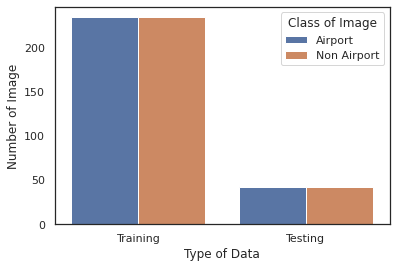

In [11]:
# Set the Seaborn style to 'white'
sns.set(style='white')

# Create a bar plot using the data from the DataFrame
sns.barplot(x='Type of Data', y='Number of Image', hue='Class of Image', data=df)

# Show the plot
plt.show()


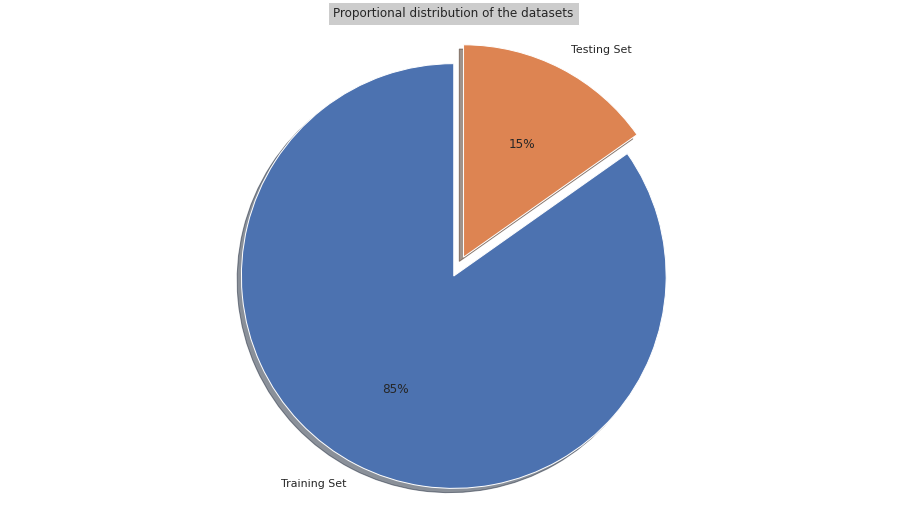

In [12]:
# Define labels and data for the pie chart
labels = ['Training Set', 'Testing Set']
data = [((img_pr_cat1[0]) * 2), ((img_pr_cat2[0]) * 2)]

# Set the figure size for the plot
plt.rcParams["figure.figsize"] = (16, 9)

# Set the explode values for the pie chart, only "explode" the 2nd slice (i.e. 'Testing Set')
explode = (0.1, 0)

# Create a pie chart subplot
fig1, ax1 = plt.subplots()
ax1.pie(data, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)

# Set equal aspect ratio to ensure the pie chart is drawn as a circle
ax1.axis('equal')

# Set the title for the pie chart with a custom bounding box
plt.title('Proportional distribution of the datasets', bbox={'facecolor': '0.8', 'pad': 5})

# Show the plot
plt.show()


In [13]:
# Iterate through the classLabels list
for i in range(len(classLabels)):
    # Call the prepareNameWithLabels function for each label in classLabels
    prepareNameWithLabels(classLabels[i])


In [14]:
# Convert the X and Y lists to NumPy arrays
X = np.asarray(X)
Y = np.asarray(Y)

# Print the X and Y NumPy arrays
print(X, Y)


['Midway_MDW_Patch5.jpg' 'ShanghaiHongqiao_SHA_Patch1.jpg'
 'Mallorca-PMI_Patch1.jpg' 'Vilnius_VNO_Patch1.jpg'
 'Fresno Yosemite_FAT_Patch1.jpg' 'Santiago_Chile-SCL_Patch2.jpg'
 'Denver_USA-DEN_Patch2.jpg' 'Munich-MUC_Patch1_m.jpg'
 'Midway_MDW_Patch2.jpg' 'Toulouse-TLS_Patch1.jpg'
 'Adelaide_Australia-ADL_Patch1.jpg' 'Paphos_PFO_Patch1.jpg'
 'Frankfurt-FRA_Patch2_m.jpg' 'Madrid-MAD_Patch2.jpg'
 'Toronto-YYZ_Patch2_m.jpg' 'WashingtonDulles-IAD_Patch2.jpg'
 'Luxemburg-LUX_Patch1.jpg' 'Detroit_DTW_Patch3.jpg'
 'Calgary_Canada-YYC_Patch2.jpg' 'Stavanger_Norway_SVG_Patch1.jpg'
 'Moskow-SVO_Patch1_m.jpg' 'Edmonton_Canada-YEG_Patch1.jpg'
 'Tunis-TUN_Patch1_m.jpg' 'Orlando_USA-MCO_Patch1.jpg'
 'Düsseldorf_DUS_Patch1.jpg' 'Detroit_DTW_Patch4.jpg'
 'LosAngelos-LAX_Patch1_m.jpg' 'Airport Ankara_ESB_Patch2.jpg'
 'Ashgabat-ASB_Patch1.jpg' 'Carrabelle_FA43_Patch1.jpg'
 'Airport Ankara_THK_Patch2.jpg' 'New_Luanda_Angola-LAD_Patch1.jpg'
 'Montreal-YUL_m.jpg' 'Wattay_VTE_Patch1.jpg'
 'Airport Amsterda

### - plot an example image from each category

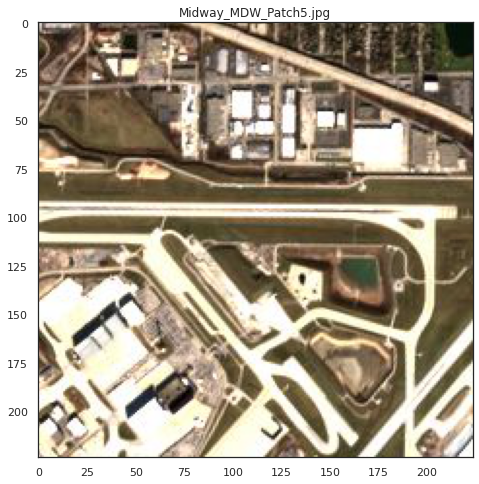

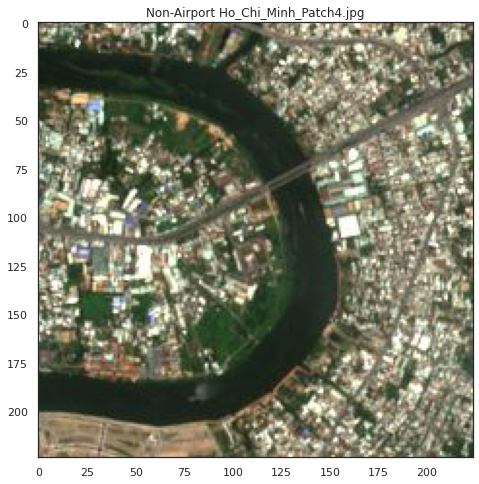

In [15]:
# We plot these examples in order to visualize the typical image quality

example_images = []

# Iterate through each subdirectory in the train_data_dir
for subdir, dirs, files in os.walk(train_data_dir):
    for file in files:
        # Construct the image file path
        img_file = os.path.join(subdir, file)
        # Load the image
        image = load_img(img_file)
        # Store the image and its title in the example_images list
        example_images.append((image, file))
        break

# Plot the example images
plt.rcParams["figure.figsize"] = (15, 8)
for img, title in example_images:
    plt.figure()
    plt.title(title)
    plt.imshow(img)

# Show the plotted images
plt.show()

# 4. Implementation of the Tranfer Learning Models

###  4.1.a VGG16: Preparing a transfer learning network

In [16]:
# Get the pre-trained VGG16 model (without the top layers) by calling the getModel function

pretrained_model_VGG16=getModel(VGG16)

2023-03-30 20:23:36.622818: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 20:23:40.233910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14797 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:01:00.0, compute capability: 7.5
2023-03-30 20:23:40.236237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14797 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:24:00.0, compute capability: 7.5
2023-03-30 20:23:40.238289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 wit

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.1.b. VGG16: Stratified K-Fold Cross validation (n folds = 5, n epochs = 10)

In [17]:
# Perform 5-fold cross-validation using the pre-trained VGG16 model and train it for 10 epochs
model_history_VGG16_2, Trained_model_VGG16_2 = Cross_val_model(pretrained_model_VGG16, n_splits=5, n_epoch=10)


Results for fold 1
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10


2023-03-30 20:23:42.547877: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


12/12 [==============================] - ETA: 0s - loss: 0.4850 - acc: 0.7876
Epoch 1: val_acc improved from -inf to 0.88298, saving model to sign_classifier.h5
12/12 [==============================] - 9s 502ms/step - loss: 0.4850 - acc: 0.7876 - val_loss: 0.3087 - val_acc: 0.8830
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.1860 - acc: 0.9247
Epoch 2: val_acc improved from 0.88298 to 0.90426, saving model to sign_classifier.h5
12/12 [==============================] - 3s 274ms/step - loss: 0.1860 - acc: 0.9247 - val_loss: 0.2251 - val_acc: 0.9043
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1015 - acc: 0.9543
Epoch 3: val_acc did not improve from 0.90426
12/12 [==============================] - 3s 252ms/step - loss: 0.1015 - acc: 0.9543 - val_loss: 0.2969 - val_acc: 0.8723
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0536 - acc: 0.9839
Epoch 4: val_acc improved from 0.90426 to 0.93617, saving model to sign_class

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 80ms/step
***Performance on Validation data***
Accuracy  : 0.9361702127659575
Precision : 0.9361702127659575
f1Score : 0.9361702127659575
[[44  3]
 [ 3 44]]
Results for fold 2
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.1756 - acc: 0.9571
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 7s 421ms/step - loss: 0.1756 - acc: 0.9571 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0327 - acc: 0.9946
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 264ms/step - loss: 0.0327 - acc: 0.9946 - val_loss: 6.8979e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0060 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 251ms/step - loss: 0.0060 - acc: 0.9973 - val_loss: 7.5425e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0012 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 253ms/st

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 82ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0040 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 4s 303ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 3.2747e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0011 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 250ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 5.7519e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 6.5797e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 256ms/step - loss: 6.5797e-04 - acc: 1.0000 - val_loss: 3.8346e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 9.5257e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [=============================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 80ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 47]]
Results for fold 4
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0030 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 5s 311ms/step - loss: 0.0030 - acc: 0.9973 - val_loss: 2.4059e-06 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 8.7051e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 257ms/step - loss: 8.7051e-04 - acc: 1.0000 - val_loss: 2.3784e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0038 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 263ms/step - loss: 0.0038 - acc: 0.9973 - val_loss: 1.3608e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 1.6150e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [=============================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 80ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 5
Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0014 - acc: 1.0000    
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 7s 518ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 3.1959e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 3.7972e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 257ms/step - loss: 3.7972e-04 - acc: 1.0000 - val_loss: 9.8148e-06 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0024 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 261ms/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 8.6357e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [=============================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 79ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[45  0]
 [ 0 47]]


### 4.1.c VGG16: Saving the Model

In [18]:
# Save the trained VGG16 model as a Keras model file
Trained_model_VGG16_2.save(outFldModels+'/VGG16_model_E10')

2023-03-30 20:26:40.838809: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/VGG16_model_E10/assets


### 4.1.d VGG16: Loading the Model

In [19]:
# Load the saved trained VGG16 model from the output folder
Final_modelVGG16_2 = models.load_model(outFldModels+'/VGG16_model_E10')

# Print the summary of the trained VGG16 model
#modelVGG16_Trained.summary()


In [20]:
# Get the configuration of the loaded model
Final_modelVGG16_2.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'vgg16_input'}},
  {'class_name': 'Functional',
   'config': {'name': 'vgg16',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 224, 224, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_1'},
      'name': 'input_1',
      'inbound_nodes': []},
     {'class_name': 'Conv2D',
      'config': {'name': 'block1_conv1',
       'trainable': False,
       'dtype': 'float32',
       'filters': 64,
       'kernel_size': (3, 3),
       'strides': (1, 1),
       'padding': 'same',
       'data_format': 'channels_last',
       'dilation_rate': (1, 1),
       'groups': 1,
       'activation': 'relu',
       'use_bias': True,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        'config': {'seed': N

### 4.1.e VGG16: Evaluation of the model accuracy

#### - Plot the learning curves

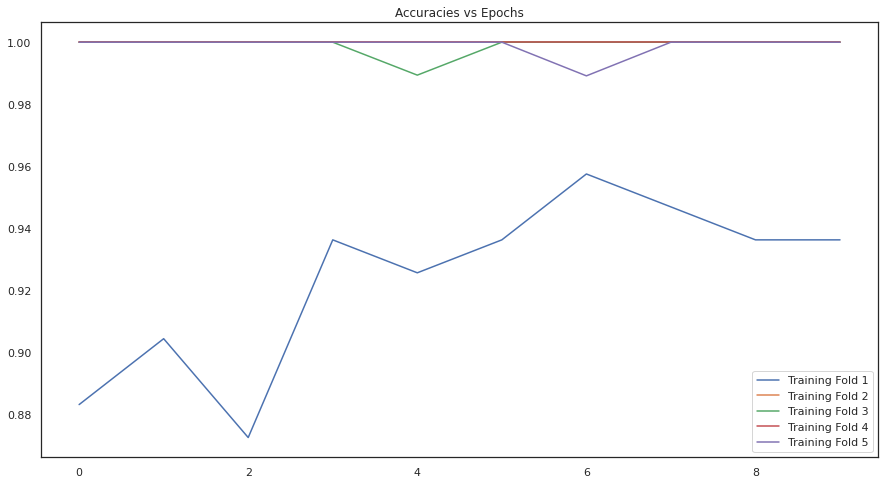

In [21]:
# Plot the learning curves for the model history
plot_learning_curves(model_history_VGG16_2)
# Display the plot
plt.show()

#### - Calculate and plot confusion matrix

/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


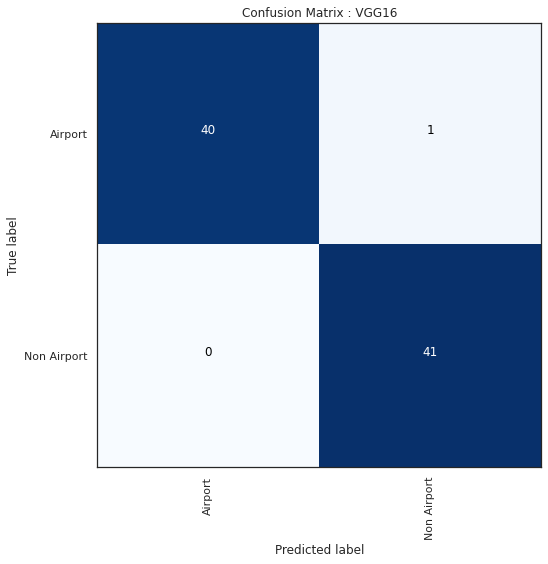

In [22]:
# Calculate confusion matrix and predicted labels for VGG16 model
cm_VGG16_2, y_pred_VGG16_2 = Calculate_ConfMatrix(Final_modelVGG16_2, test_generator)

# Plot the confusion matrix for VGG16 model
plot_confusion_matrix(cm_VGG16_2, classes=category_names, title='Confusion Matrix : VGG16', normalize=False, figname='Confusion_matrix_concrete.jpg')

# Show the plotted confusion matrix
plt.show()


#### - Calculate the final accuracy

In [23]:
# Calculate accuracy score for VGG16 model on test set
accuracy_VGG16 = accuracy_score(test_generator.classes, y_pred_VGG16_2)

# Print the accuracy score as a percentage
print("Accuracy in test set: %0.1f%% " % (accuracy_VGG16 * 100))

Accuracy in test set: 98.8% 


Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.6799 - acc: 0.7581
Epoch 1: val_acc improved from -inf to 0.56383, saving model to sign_classifier.h5
12/12 [==============================] - 39s 1s/step - loss: 0.6799 - acc: 0.7581 - val_loss: 1.4987 - val_acc: 0.5638
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.1212 - acc: 0.9677
Epoch 2: val_acc improved from 0.56383 to 0.73404, saving model to sign_classifier.h5
12/12 [==============================] - 6s 532ms/step - loss: 0.1212 - acc: 0.9677 - val_loss: 0.7679 - val_acc: 0.7340
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0630 - acc: 0.9785
Epoch 3: val_acc did not improve from 0.73404
12/12 [==============================] - 4s 340ms/step - loss: 0.0630 - acc: 0.9785 - val_loss: 1.6277 - val_acc: 0.6277
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0446 - acc: 0.9758
Epoch 4: val_acc improved from 0.73404 to 0.89362, saving model to s

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 2s 85ms/step
***Performance on Validation data***
Accuracy  : 0.9042553191489362
Precision : 0.9059090909090909
f1Score : 0.904157697972131
[[44  3]
 [ 6 41]]
Results for fold 2
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.1523 - acc: 0.9598
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 36s 1s/step - loss: 0.1523 - acc: 0.9598 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0153 - acc: 0.9946
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 341ms/step - loss: 0.0153 - acc: 0.9946 - val_loss: 0.0429 - val_acc: 0.9892
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0160 - acc: 0.9946
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 349ms/step - loss: 0.0160 - acc: 0.9946 - val_loss: 0.0138 - val_acc: 0.9892
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0085 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 338ms/step - loss:

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 2s 84ms/step
***Performance on Validation data***
Accuracy  : 0.989247311827957
Precision : 0.9894713261648745
f1Score : 0.9892448242193573
[[47  0]
 [ 1 45]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0084 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 30s 679ms/step - loss: 0.0084 - acc: 0.9973 - val_loss: 7.6893e-04 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0034 - acc: 0.9973
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 343ms/step - loss: 0.0034 - acc: 0.9973 - val_loss: 4.0025e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 6.0074e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 339ms/step - loss: 6.0074e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0019 - acc: 1.0000 
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 4

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 2s 85ms/step
***Performance on Validation data***
Accuracy  : 0.9893617021276596
Precision : 0.9895833333333333
f1Score : 0.9893604980192416
[[46  1]
 [ 0 47]]
Results for fold 4
Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0029 - acc: 1.0000   
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 36s 1s/step - loss: 0.0029 - acc: 1.0000 - val_loss: 2.6304e-07 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 9.0891e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 339ms/step - loss: 9.0891e-04 - acc: 1.0000 - val_loss: 3.9634e-06 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 7.0285e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 339ms/step - loss: 7.0285e-04 - acc: 1.0000 - val_loss: 6.9561e-05 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0091 - acc: 0.9947
Epoch 4: val_acc did not improve from 1.00000
12/12 [========================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 2s 86ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 46]]
Results for fold 5
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 7.5972e-04 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 31s 651ms/step - loss: 7.5972e-04 - acc: 1.0000 - val_loss: 4.9991e-08 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0635 - acc: 0.9920
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 337ms/step - loss: 0.0635 - acc: 0.9920 - val_loss: 8.7546e-07 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0140 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 4s 349ms/step - loss: 0.0140 - acc: 0.9973 - val_loss: 2.9994e-07 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 8.9901e-06 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [============================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 2s 82ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]


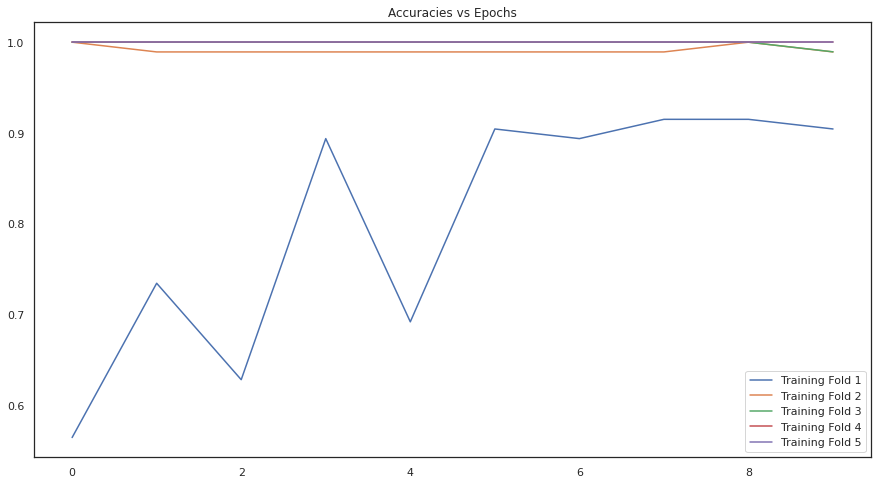

In [24]:
# Load the DenseNet201 model
pretrained_model_DenseNet201 = getModel(DenseNet201)

# Train the model and get its history
model_history_DenseNet201, Trained_model_DenseNet201 = Cross_val_model(pretrained_model_DenseNet201)

# Plot the learning curves of the trained model
plot_learning_curves(model_history_DenseNet201)

# Show the plot
plt.show()



In [25]:
# Save the trained model to the designated output folder
Trained_model_DenseNet201.save(outFldModels+'/new_DenseNet201')

# Load the saved model from the output folder
Final_model_DenseNet201 = models.load_model(outFldModels+'/new_DenseNet201')


INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_DenseNet201/assets


/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


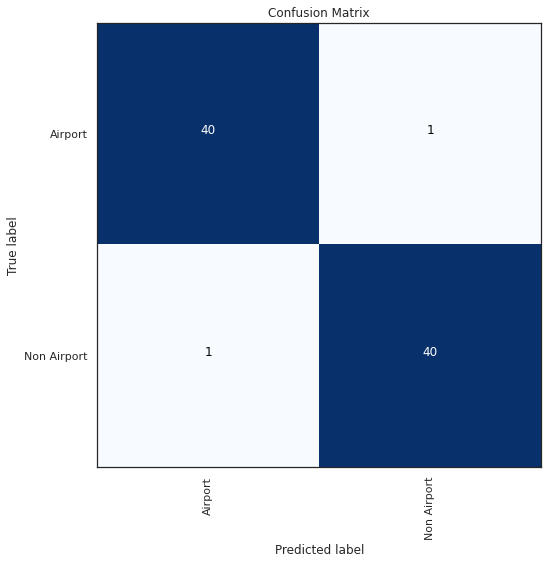

Accuracy in test set: 97.6% 


In [26]:
# Calculate the confusion matrix and predicted values for the test generator using DenseNet201 model
cm_DenseNet201, y_pred_DenseNet201 = Calculate_ConfMatrix(Final_model_DenseNet201, test_generator)

# Plot the confusion matrix
plot_confusion_matrix(cm_DenseNet201, classes=category_names, title='Confusion Matrix', normalize=False, figname='Confusion_matrix_concrete.jpg')

# Show the plot
plt.show()

# Calculate the accuracy score for the test set
accuracy_DenseNet201 = accuracy_score(test_generator.classes, y_pred_DenseNet201)

# Print the accuracy score for the test set
print("Accuracy in test set: %0.1f%% " % (accuracy_DenseNet201 * 100))


In [27]:
# Get the InceptionV3 model
pretrained_model_InceptionV3 = getModel(InceptionV3)

# Train the model using cross-validation
model_history_InceptionV3, Trained_model_InceptionV3 = Cross_val_model(pretrained_model_InceptionV3)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.7319
Epoch 1: val_acc improved from -inf to 0.65591, saving model to sign_classifier.h5
12/12 [==============================] - 15s 576ms/step - loss: 0.6794 - acc: 0.7319 - val_loss: 1.1728 - val_acc: 0.6559
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.2868 - acc: 0.8847
Epoch 2: val_acc improved from 0.65591 to 0.87097, saving model to sign_classifier.h5
12/12 [==============================] - 4s 327ms/step - loss: 0.2868 - acc: 0.8847 - val_loss: 0.5029 - val_acc: 0.8710
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0954 - acc: 0.9732
Epoch 3: val_acc did not improve from 0.87097
12/12 [==============================] - 3s 240ms/step - loss: 0.0954 - acc: 0.9732 - val_loss: 1.0616 - val_acc: 0.7527
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0470 - acc: 0.9893
Epoch 4: val_acc did not improve from 0.87097
12/12 [============

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 40ms/step
***Performance on Validation data***
Accuracy  : 0.956989247311828
Precision : 0.9604301075268816
f1Score : 0.9569295101553166
[[46  0]
 [ 4 43]]
Results for fold 2
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0906 - acc: 0.9785
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 16s 585ms/step - loss: 0.0906 - acc: 0.9785 - val_loss: 0.0098 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0771 - acc: 0.9839
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 246ms/step - loss: 0.0771 - acc: 0.9839 - val_loss: 6.3448e-05 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0147 - acc: 0.9946
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 241ms/step - loss: 0.0147 - acc: 0.9946 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0299 - acc: 0.9946
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 244ms/step 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 43ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 47]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0119 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 11s 404ms/step - loss: 0.0119 - acc: 0.9973 - val_loss: 5.9255e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0419 - acc: 0.9919
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 248ms/step - loss: 0.0419 - acc: 0.9919 - val_loss: 1.1163e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0096 - acc: 0.9946
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 240ms/step - loss: 0.0096 - acc: 0.9946 - val_loss: 1.0898e-05 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.9892
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 244

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 42ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 47]]
Results for fold 4
Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0179 - acc: 0.9973   
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 13s 484ms/step - loss: 0.0179 - acc: 0.9973 - val_loss: 2.1431e-06 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0220 - acc: 0.9920 
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 252ms/step - loss: 0.0220 - acc: 0.9920 - val_loss: 2.1464e-05 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0618 - acc: 0.9947    
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 241ms/step - loss: 0.0618 - acc: 0.9947 - val_loss: 1.0080e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0045 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 38ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 45]]
Results for fold 5
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0057 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 12s 423ms/step - loss: 0.0057 - acc: 0.9973 - val_loss: 2.1662e-04 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0068 - acc: 0.9973
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 248ms/step - loss: 0.0068 - acc: 0.9973 - val_loss: 1.8825e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 5.2220e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 237ms/step - loss: 5.2220e-04 - acc: 1.0000 - val_loss: 6.6259e-06 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 39ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.5339 - acc: 0.7527
Epoch 1: val_acc improved from -inf to 0.60638, saving model to sign_classifier.h5
12/12 [==============================] - 11s 411ms/step - loss: 0.5339 - acc: 0.7527 - val_loss: 1.7892 - val_acc: 0.6064
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.2564 - acc: 0.9220
Epoch 2: val_acc improved from 0.60638 to 0.71277, saving model to sign_classifier.h5
12/12 [==============================] - 4s 320ms/step - loss: 0.2564 - acc: 0.9220 - val_loss: 1.3481 - val_acc: 0.7128
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0916 - acc: 0.9651
Epoch 3: val_acc did not improve from 0.71277
12/12 [==============================] - 3s 241ms/step - loss: 0.0916 - acc: 0.9651 - val_loss: 1.4561 - val_acc: 0.7021
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.1468 - acc: 0.9301
Epoch 4: val_acc improved from 0.71277 to 0.95745, saving model t

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 39ms/step
***Performance on Validation data***
Accuracy  : 0.8936170212765957
Precision : 0.9122807017543859
f1Score : 0.8923992673992676
[[47  0]
 [10 37]]
Results for fold 2
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.1083 - acc: 0.9732
Epoch 1: val_acc improved from -inf to 0.97849, saving model to sign_classifier.h5
12/12 [==============================] - 16s 413ms/step - loss: 0.1083 - acc: 0.9732 - val_loss: 0.0406 - val_acc: 0.9785
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0974 - acc: 0.9786
Epoch 2: val_acc did not improve from 0.97849
12/12 [==============================] - 3s 249ms/step - loss: 0.0974 - acc: 0.9786 - val_loss: 0.0334 - val_acc: 0.9785
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0559 - acc: 0.9839
Epoch 3: val_acc improved from 0.97849 to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 4s 323ms/step - loss: 0.0559 - acc: 0.9839 - val_loss: 6.7007e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0178 - acc: 0.9946
Epoch 4: val_acc did not improve from 1.00000
12/12 [========

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 37ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 3
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0178 - acc: 0.9946
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 11s 417ms/step - loss: 0.0178 - acc: 0.9946 - val_loss: 2.9865e-06 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0039 - acc: 0.9973    
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 243ms/step - loss: 0.0039 - acc: 0.9973 - val_loss: 5.1706e-06 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0080 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 242ms/step - loss: 0.0080 - acc: 0.9973 - val_loss: 4.4759e-06 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0076 - acc: 0.9946
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 38ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]
Results for fold 4
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0037 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 11s 410ms/step - loss: 0.0037 - acc: 0.9973 - val_loss: 1.4769e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 9.2761e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 243ms/step - loss: 9.2761e-04 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 2.2991e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 248ms/step - loss: 2.2991e-04 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9892
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0057 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 36ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 5
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0049 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 0.98925, saving model to sign_classifier.h5
12/12 [==============================] - 11s 407ms/step - loss: 0.0049 - acc: 0.9973 - val_loss: 0.0162 - val_acc: 0.9892
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 2: val_acc did not improve from 0.98925
12/12 [==============================] - 3s 245ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9892
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0033 - acc: 0.9973
Epoch 3: val_acc did not improve from 0.98925
12/12 [==============================] - 3s 239ms/step - loss: 0.0033 - acc: 0.9973 - val_loss: 0.0185 - val_acc: 0.9892
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.9973
Epoch 4: val_acc did not improve from 0.98925
12/12 [==============================] - 3s 240ms/step - lo

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 37ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]


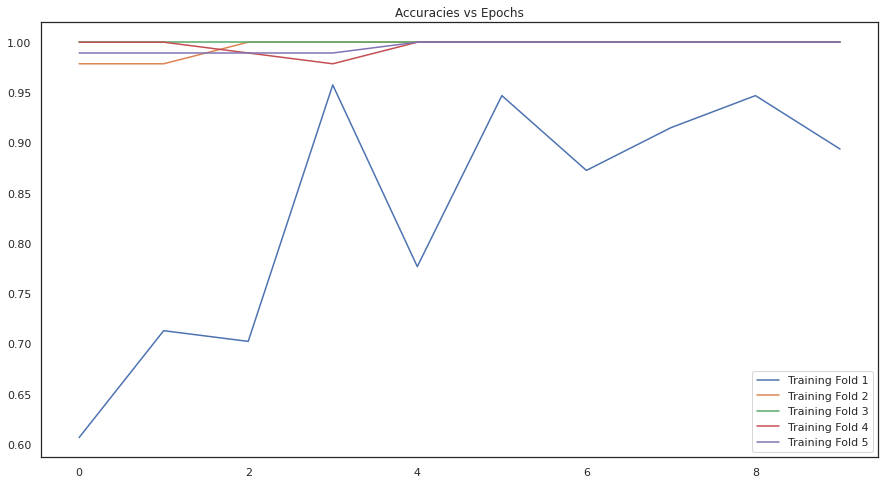

INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_InceptionV3/assets


/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


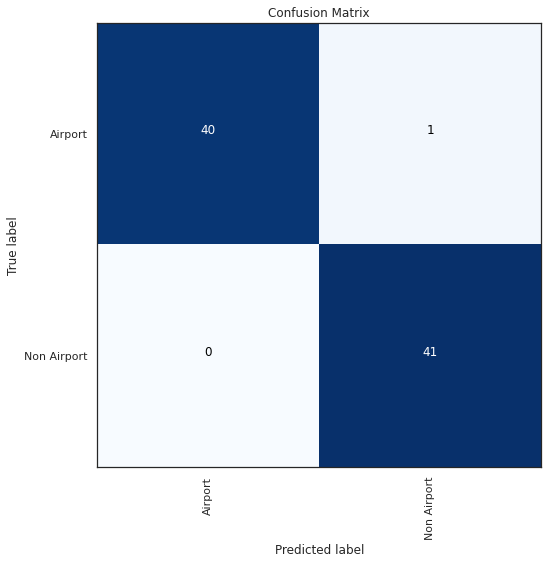

Accuracy in test set: 98.8% 


In [28]:
# Define the pretrained model
pretrained_model_InceptionV3 = getModel(InceptionV3)

# Train the model and get the model history and trained model
model_history_InceptionV3, Trained_model_InceptionV3 = Cross_val_model(pretrained_model_InceptionV3)

# Plot the learning curves for the trained model
plot_learning_curves(model_history_InceptionV3)

# Save the trained model
Trained_model_InceptionV3.save(outFldModels+'/new_InceptionV3')

# Load the saved trained model
Final_model_InceptionV3 = models.load_model(outFldModels+'/new_InceptionV3')

# Calculate the confusion matrix and predicted labels
cm_InceptionV3, y_pred_InceptionV3 = Calculate_ConfMatrix(Final_model_InceptionV3, test_generator)

# Plot the confusion matrix
plot_confusion_matrix(cm_InceptionV3, classes=category_names, title='Confusion Matrix', normalize=False, figname='Confusion_matrix_concrete.jpg')

# Show the plot
plt.show()

# Calculate and print the accuracy in the test set
accuracy_InceptionV3 = accuracy_score(test_generator.classes, y_pred_InceptionV3)
print("Accuracy in test set: %0.1f%% " % (accuracy_InceptionV3 * 100))

In [29]:
# Load the MobileNet model pre-trained on ImageNet
pretrained_model_MobileNet = getModel(MobileNet)

# Cross-validate the MobileNet model and store the model history and trained model
model_history_MobileNet, Trained_model_MobileNet = Cross_val_model(pretrained_model_MobileNet)


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 2.1221 - acc: 0.6075
Epoch 1: val_acc improved from -inf to 0.81915, saving model to sign_classifier.h5
12/12 [==============================] - 6s 309ms/step - loss: 2.1221 - acc: 0.6075 - val_loss: 0.4388 - val_acc: 0.8191
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.4529 - acc: 0.8495
Epoch 2: val_acc did not improve from 0.81915
12/12 [==============================] - 3s 246ms/step - loss: 0.4529 - acc: 0.8495 - val_loss: 0.4980 - val_acc: 0.7660
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.4873 - acc: 0.8468
Epoch 3: val_acc improved from 0.81915 to 0.87234, saving model to sign_classifier.h5
12/12 [==============================] - 3s 263ms/step - loss: 0.4873 - acc: 0.8468 - val_loss: 0.2673 - val_acc: 0.8723
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.1975 - acc: 0.9435
Epoch 4: val_acc did not improve from 0.87234
12/12 [=============

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 32ms/step
***Performance on Validation data***
Accuracy  : 0.9574468085106383
Precision : 0.9582766439909296
f1Score : 0.957427536231884
[[44  3]
 [ 1 46]]
Results for fold 2
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0693 - acc: 0.9705
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 332ms/step - loss: 0.0693 - acc: 0.9705 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0805 - acc: 0.9705
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 252ms/step - loss: 0.0805 - acc: 0.9705 - val_loss: 0.1629 - val_acc: 0.9247
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0147 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 238ms/step - loss: 0.0147 - acc: 0.9973 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0056 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 247ms/step - los

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 34ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0215 - acc: 0.9946
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 303ms/step - loss: 0.0215 - acc: 0.9946 - val_loss: 3.8798e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0173 - acc: 0.9946
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 254ms/step - loss: 0.0173 - acc: 0.9946 - val_loss: 3.2738e-05 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0015 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 241ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.0835e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0074 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 240m

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 36ms/step
***Performance on Validation data***
Accuracy  : 0.9893617021276596
Precision : 0.9895833333333333
f1Score : 0.9893604980192416
[[46  1]
 [ 0 47]]
Results for fold 4
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 309ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0118 - acc: 0.9946
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 248ms/step - loss: 0.0118 - acc: 0.9946 - val_loss: 4.1659e-07 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0026 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 239ms/step - loss: 0.0026 - acc: 0.9973 - val_loss: 5.4005e-06 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0432 - acc: 0.9866
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 241ms/st

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 35ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 5
Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0088 - acc: 0.9947
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 331ms/step - loss: 0.0088 - acc: 0.9947 - val_loss: 8.0929e-06 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 8.3809e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 247ms/step - loss: 8.3809e-04 - acc: 1.0000 - val_loss: 3.8873e-08 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 3.5061e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 239ms/step - loss: 3.5061e-04 - acc: 1.0000 - val_loss: 5.6718e-06 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0277 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [=========================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 32ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 46]]


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.8368 - acc: 0.7151
Epoch 1: val_acc improved from -inf to 0.86170, saving model to sign_classifier.h5
12/12 [==============================] - 6s 312ms/step - loss: 0.8368 - acc: 0.7151 - val_loss: 0.4621 - val_acc: 0.8617
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.2572 - acc: 0.9086
Epoch 2: val_acc improved from 0.86170 to 0.91489, saving model to sign_classifier.h5
12/12 [==============================] - 3s 274ms/step - loss: 0.2572 - acc: 0.9086 - val_loss: 0.2712 - val_acc: 0.9149
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1891 - acc: 0.9140
Epoch 3: val_acc did not improve from 0.91489
12/12 [==============================] - 3s 242ms/step - loss: 0.1891 - acc: 0.9140 - val_loss: 0.2481 - val_acc: 0.9149
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.2179 - acc: 0.9247
Epoch 4: val_acc did not improve from 0.91489
12/12 [=============

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 38ms/step
***Performance on Validation data***
Accuracy  : 0.9680851063829787
Precision : 0.9682971014492754
f1Score : 0.9680814940577249
[[46  1]
 [ 2 45]]
Results for fold 2
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0664 - acc: 0.9732
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 307ms/step - loss: 0.0664 - acc: 0.9732 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0325 - acc: 0.9946
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 242ms/step - loss: 0.0325 - acc: 0.9946 - val_loss: 0.1080 - val_acc: 0.9677
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0212 - acc: 0.9946
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 243ms/step - loss: 0.0212 - acc: 0.9946 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0150 - acc: 0.9920
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 241ms/step - los

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 40ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 3
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0153 - acc: 0.9920
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 316ms/step - loss: 0.0153 - acc: 0.9920 - val_loss: 2.8907e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0235 - acc: 0.9973
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 247ms/step - loss: 0.0235 - acc: 0.9973 - val_loss: 1.2324e-05 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0061 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 240ms/step - loss: 0.0061 - acc: 0.9973 - val_loss: 2.6481e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0160 - acc: 0.9920
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 242m

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 33ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]
Results for fold 4
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0116 - acc: 0.9920
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 305ms/step - loss: 0.0116 - acc: 0.9920 - val_loss: 1.6381e-06 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.9973
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 243ms/step - loss: 0.0031 - acc: 0.9973 - val_loss: 5.5293e-06 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0053 - acc: 0.9973 
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 239ms/step - loss: 0.0053 - acc: 0.9973 - val_loss: 3.9938e-06 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0058 - acc: 0.9973
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 240

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 38ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 46]]
Results for fold 5
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0092 - acc: 0.9973
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 6s 307ms/step - loss: 0.0092 - acc: 0.9973 - val_loss: 8.1138e-07 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 2.6663e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 246ms/step - loss: 2.6663e-04 - acc: 1.0000 - val_loss: 6.5373e-08 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0233 - acc: 0.9893
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 250ms/step - loss: 0.0233 - acc: 0.9893 - val_loss: 6.7294e-07 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0017 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] -

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 39ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]


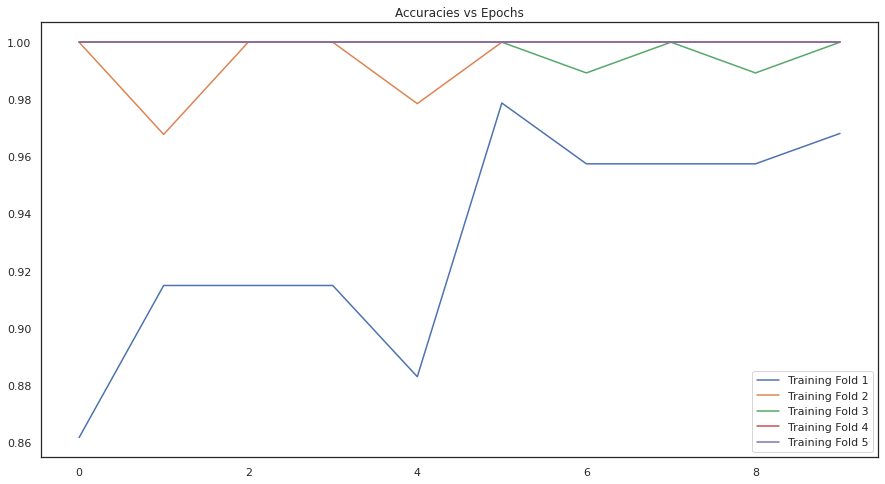

INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_MobileNet/assets


INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_MobileNet/assets
/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


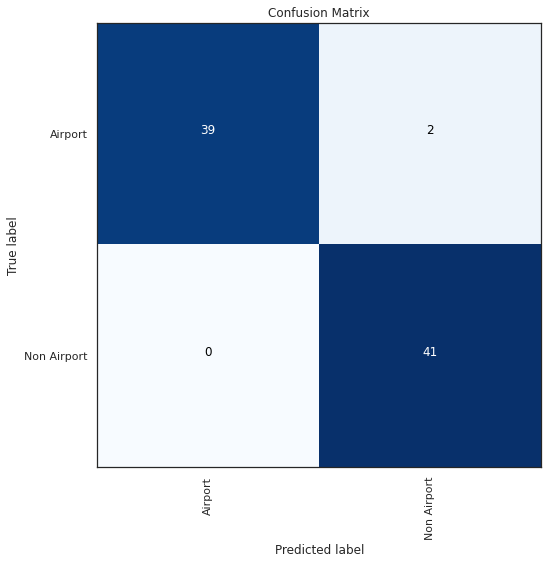

Accuracy in test set: 97.6% 


In [30]:
# Get the pre-trained MobileNet model
pretrained_model_MobileNet = getModel(MobileNet)

# Train the MobileNet model and get the model history and trained model
model_history_MobileNet, Trained_model_MobileNet = Cross_val_model(pretrained_model_MobileNet)

# Plot the learning curves for the trained model
plot_learning_curves(model_history_MobileNet)

# Save the trained MobileNet model
Trained_model_MobileNet.save(outFldModels+'/new_MobileNet')

# Load the saved MobileNet model
Final_model_MobileNet = models.load_model(outFldModels+'/new_MobileNet')

# Calculate the confusion matrix and predicted class labels for the MobileNet model
cm_MobileNet, y_pred_MobileNet = Calculate_ConfMatrix(Final_model_MobileNet, test_generator)

# Plot the confusion matrix for the MobileNet model
plot_confusion_matrix(cm_MobileNet, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

# Show the plotted confusion matrix
plt.show()

# Calculate the accuracy of the MobileNet model
accuracy_MobileNet = accuracy_score(test_generator.classes, y_pred_MobileNet)

# Print the accuracy of the MobileNet model
print("Accuracy in test set: %0.1f%% " % (accuracy_MobileNet * 100))


In [31]:
# Load the Xception model with ImageNet weights
pretrained_model_Xception = getModel(Xception)

# Train the model using cross-validation
model_history_Xception, Trained_model_Xception = Cross_val_model(pretrained_model_Xception)


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.5514 - acc: 0.7024
Epoch 1: val_acc improved from -inf to 0.76344, saving model to sign_classifier.h5
12/12 [==============================] - 12s 513ms/step - loss: 0.5514 - acc: 0.7024 - val_loss: 0.5067 - val_acc: 0.7634
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.2233 - acc: 0.8981
Epoch 2: val_acc did not improve from 0.76344
12/12 [==============================] - 3s 255ms/step - loss: 0.2233 - acc: 0.8981 - val_loss: 0.5738 - val_acc: 0.7527
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1689 - acc: 0.9303
Epoch 3: val_acc improved from 0.76344 to 0.86022, saving model to sign_classifier.h5
12/12 [==============================] - 4s 322ms/step - loss: 0.1689 - acc: 0.9303 - val_loss: 0.3405 - val_acc: 0.8602
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0885 - acc: 0.9625
Epoch 4: val_acc improved from 0.86022 to 0.94624, saving model t

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 62ms/step
***Performance on Validation data***
Accuracy  : 0.956989247311828
Precision : 0.9603626396795277
f1Score : 0.9568895006683026
[[47  0]
 [ 4 42]]
Results for fold 2
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0409 - acc: 0.9892
Epoch 1: val_acc improved from -inf to 0.98936, saving model to sign_classifier.h5
12/12 [==============================] - 10s 509ms/step - loss: 0.0409 - acc: 0.9892 - val_loss: 0.0282 - val_acc: 0.9894
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0101 - acc: 0.9946
Epoch 2: val_acc improved from 0.98936 to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 4s 321ms/step - loss: 0.0101 - acc: 0.9946 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0146 - acc: 0.9946
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 252ms/step - loss: 0.0146 - acc: 0.9946 - val_loss: 0.0332 - val_acc: 0.9894
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0157 - acc: 0.9946
Epoch 4: val_acc did not improve from 1.00000
12/12 [============

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 60ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 47]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 9.5081e-04 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 9s 383ms/step - loss: 9.5081e-04 - acc: 1.0000 - val_loss: 1.7158e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 262ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0111 - acc: 0.9946
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 255ms/step - loss: 0.0111 - acc: 0.9946 - val_loss: 1.0917e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0012 - acc: 1.0000   
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 60ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 47]]
Results for fold 4
Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0229 - acc: 0.9920
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 10s 515ms/step - loss: 0.0229 - acc: 0.9920 - val_loss: 2.2209e-06 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0144 - acc: 0.9920
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 257ms/step - loss: 0.0144 - acc: 0.9920 - val_loss: 1.1659e-05 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 1.7260e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 256ms/step - loss: 1.7260e-04 - acc: 1.0000 - val_loss: 1.4143e-05 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 60ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 46]]
Results for fold 5
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 5.3742e-04 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 14s 381ms/step - loss: 5.3742e-04 - acc: 1.0000 - val_loss: 7.9156e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.4110e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 258ms/step - loss: 1.4110e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0072 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 255ms/step - loss: 0.0072 - acc: 0.9973 - val_loss: 1.9636e-06 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 6.4449e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [========================

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 60ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[46  0]
 [ 0 47]]


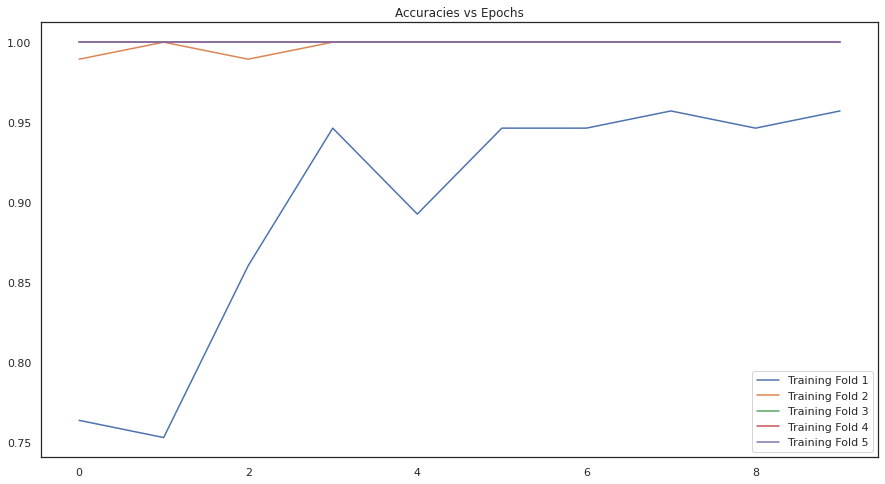

INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_Xception/assets


INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_Xception/assets
/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


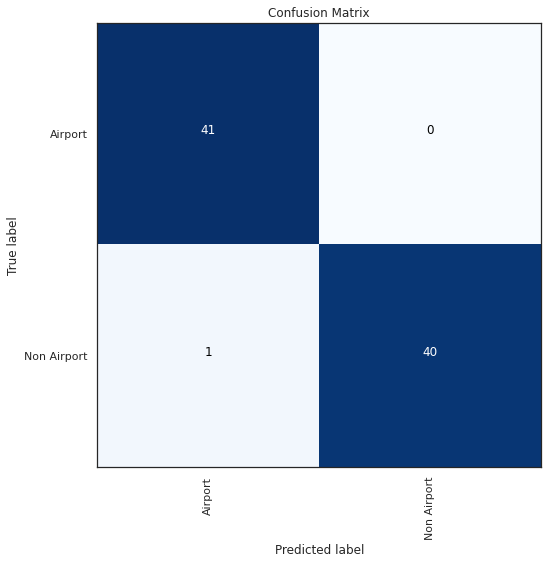

Accuracy in test set: 98.8% 


In [32]:
# Plot the learning curves for Xception model
plot_learning_curves(model_history_Xception)

# Save the trained Xception model
Trained_model_Xception.save(outFldModels+'/new_Xception')

# Load the saved Xception model
Final_model_Xception = models.load_model(outFldModels+'/new_Xception')

# Calculate the confusion matrix and predicted labels for the Xception model
cm_Xception, y_pred_Xception=Calculate_ConfMatrix(Final_model_Xception, test_generator)    

# Plot the confusion matrix for the Xception model
plot_confusion_matrix(cm_Xception, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

# Show the plot of the confusion matrix for the Xception model
plt.show()


# Calculate the accuracy of the Xception model on the test set and print it to the console
accuracy_Xception = accuracy_score(test_generator.classes, y_pred_Xception)
print("Accuracy in test set: %0.1f%% " % (accuracy_Xception * 100))


In [33]:
# Load the VGG19 model with pre-trained weights
pretrained_model_VGG19 = getModel(VGG19)

# Train the model using cross-validation and save the model history and trained model
model_history_VGG19, Trained_model_VGG19 = Cross_val_model(pretrained_model_VGG19)


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.5835 - acc: 0.6962
Epoch 1: val_acc improved from -inf to 0.85106, saving model to sign_classifier.h5
12/12 [==============================] - 5s 304ms/step - loss: 0.5835 - acc: 0.6962 - val_loss: 0.3272 - val_acc: 0.8511
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.2333 - acc: 0.8978
Epoch 2: val_acc did not improve from 0.85106
12/12 [==============================] - 3s 261ms/step - loss: 0.2333 - acc: 0.8978 - val_loss: 0.2287 - val_acc: 0.8298
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1046 - acc: 0.9677
Epoch 3: val_acc improved from 0.85106 to 0.92553, saving model to sign_classifier.h5
12/12 [==============================] - 4s 288ms/step - loss: 0.1046 - acc: 0.9677 - val_loss: 0.1248 - val_acc: 0.9255
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0329 - acc: 0.9892
Epoch 4: val_acc improved from 0.92553 to 0.95745, saving model to

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 94ms/step
***Performance on Validation data***
Accuracy  : 0.9574468085106383
Precision : 0.9574468085106383
f1Score : 0.9574468085106385
[[45  2]
 [ 2 45]]
Results for fold 2
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0642 - acc: 0.9812
Epoch 1: val_acc improved from -inf to 0.94624, saving model to sign_classifier.h5
12/12 [==============================] - 4s 313ms/step - loss: 0.0642 - acc: 0.9812 - val_loss: 0.1755 - val_acc: 0.9462
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0379 - acc: 0.9866
Epoch 2: val_acc improved from 0.94624 to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 4s 288ms/step - loss: 0.0379 - acc: 0.9866 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 254ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0666 - val_acc: 0.9677
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0018 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [=============

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 94ms/step
***Performance on Validation data***
Accuracy  : 0.967741935483871
Precision : 0.9679510155316607
f1Score : 0.9677344726580719
[[44  2]
 [ 1 46]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0559 - acc: 0.9866
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 5s 314ms/step - loss: 0.0559 - acc: 0.9866 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0140 - acc: 0.9973
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 259ms/step - loss: 0.0140 - acc: 0.9973 - val_loss: 2.0025e-05 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0029 - acc: 0.9973    
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 257ms/step - loss: 0.0029 - acc: 0.9973 - val_loss: 1.3083e-04 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 9.3701e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 94ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 47]]
Results for fold 4
Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.9973 
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 5s 323ms/step - loss: 0.0162 - acc: 0.9973 - val_loss: 6.1289e-05 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0034 - acc: 1.0000 
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 261ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 1.0603e-04 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 7.3851e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 264ms/step - loss: 7.3851e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 5.8795e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================]

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 94ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[47  0]
 [ 0 45]]
Results for fold 5
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.9793e-05 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to sign_classifier.h5
12/12 [==============================] - 4s 314ms/step - loss: 1.9793e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 258ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 8.9468e-07 - val_acc: 1.0000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0227 - acc: 0.9973
Epoch 3: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 256ms/step - loss: 0.0227 - acc: 0.9973 - val_loss: 9.2059e-05 - val_acc: 1.0000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0125 - acc: 0.9946
Epoch 4: val_acc did not improve from 1.00000
12/12 [==============================] - 3s 

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 0s 95ms/step
***Performance on Validation data***
Accuracy  : 0.967741935483871
Precision : 0.9696774193548388
f1Score : 0.9676970962884355
[[43  3]
 [ 0 47]]


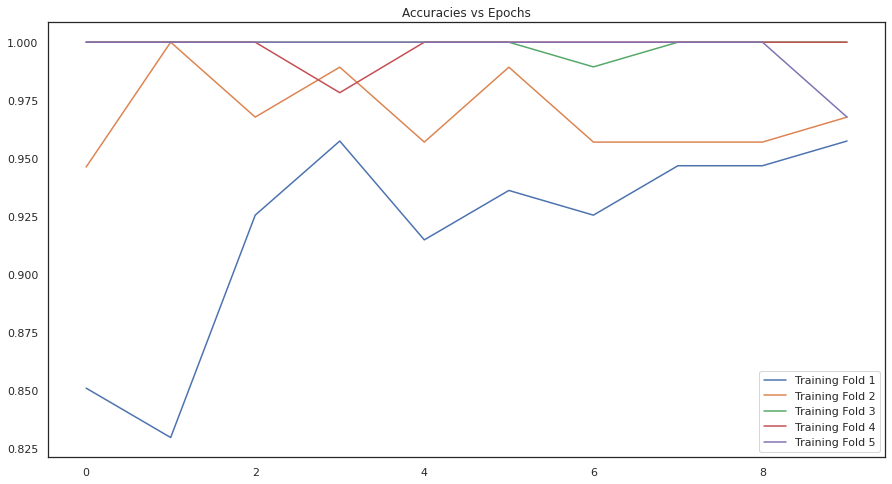

INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_VGG19/assets


INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_VGG19/assets
/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


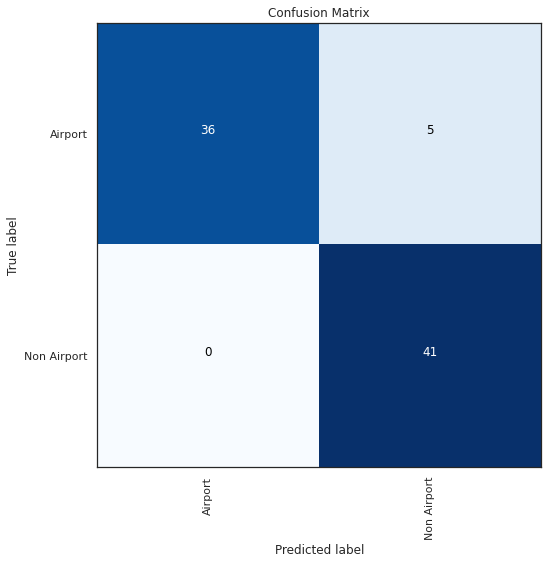

Accuracy in test set: 93.9% 


In [34]:
# plot learning curves
plot_learning_curves(model_history_VGG19)

# save trained model
Trained_model_VGG19.save(outFldModels+'/new_VGG19')

# load saved model
Final_model_VGG19 = models.load_model(outFldModels+'/new_VGG19')

# calculate confusion matrix and predicted labels
cm_VGG19, y_pred_VGG19 = Calculate_ConfMatrix(Final_model_VGG19, test_generator)    

# plot confusion matrix
plot_confusion_matrix(cm_VGG19, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')
# Show the plot of the confusion matrix for the Xception model
plt.show()


# calculate accuracy and print
accuracy_VGG19 = accuracy_score(test_generator.classes, y_pred_VGG19)
print("Accuracy in test set: %0.1f%% " % (accuracy_VGG19 * 100))


In [35]:
# Get the ResNet50 model
pretrained_model_ResNet50 = getModel(ResNet50)

# Train the model and store the training history and trained model
model_history_ResNet50, Trained_model_ResNet50 = Cross_val_model(pretrained_model_ResNet50)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.5452 - acc: 0.7312
Epoch 1: val_acc improved from -inf to 0.51064, saving model to sign_classifier.h5
12/12 [==============================] - 13s 492ms/step - loss: 1.5452 - acc: 0.7312 - val_loss: 0.8480 - val_acc: 0.5106
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.5068 - acc: 0.8898
Epoch 2: val_acc did not improve from 0.51064
12/12 [==============================] - 3s 252ms/step - loss: 0.5068 - acc: 0.8898 - val_loss: 0.8075 - val_acc: 0.4894
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.2475 - acc: 0.9489
Epoch 3: val_acc did not improve from 0.51064
12/12 [==============================] - 3s 248ms/step - loss: 0.2475 - acc: 0.9489 - val_loss: 0.8398 - val_acc: 0.5106
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.1823 - acc: 0.9758
Epoch 4: val_acc did not improve from 0.51064
12/12 [==============================] - 3s 249ms/step - lo

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 58ms/step
***Performance on Validation data***
Accuracy  : 0.48936170212765956
Precision : 0.24731182795698922
f1Score : 0.32857142857142857
[[ 0 47]
 [ 1 46]]
Results for fold 2
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.4372 - acc: 0.9489
Epoch 1: val_acc improved from -inf to 0.50000, saving model to sign_classifier.h5
12/12 [==============================] - 11s 399ms/step - loss: 0.4372 - acc: 0.9489 - val_loss: 1.6332 - val_acc: 0.5000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0431 - acc: 0.9785
Epoch 2: val_acc did not improve from 0.50000
12/12 [==============================] - 3s 252ms/step - loss: 0.0431 - acc: 0.9785 - val_loss: 1.6867 - val_acc: 0.5000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0269 - acc: 0.9866
Epoch 3: val_acc did not improve from 0.50000
12/12 [==============================] - 3s 249ms/step - loss: 0.0269 - acc: 0.9866 - val_loss: 2.6264 - val_acc: 0.5000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0183 - acc: 0.9919
Epoch 4: val_acc did not improve from 0.50000
12/12 [==============================] - 3s 252ms/step - lo

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 59ms/step
***Performance on Validation data***
Accuracy  : 0.5
Precision : 0.25
f1Score : 0.3333333333333333
[[ 0 47]
 [ 0 47]]
Results for fold 3
Found 372 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0810 - acc: 0.9812
Epoch 1: val_acc improved from -inf to 0.50000, saving model to sign_classifier.h5
12/12 [==============================] - 11s 398ms/step - loss: 0.0810 - acc: 0.9812 - val_loss: 9.8297 - val_acc: 0.5000
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.9892
Epoch 2: val_acc did not improve from 0.50000
12/12 [==============================] - 3s 252ms/step - loss: 0.0609 - acc: 0.9892 - val_loss: 8.0813 - val_acc: 0.5000
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0930 - acc: 0.9866 
Epoch 3: val_acc did not improve from 0.50000
12/12 [==============================] - 3s 249ms/step - loss: 0.0930 - acc: 0.9866 - val_loss: 7.4856 - val_acc: 0.5000
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0134 - acc: 0.9973
Epoch 4: val_acc did not improve from 0.50000
12/12 [==============================] - 3s 249ms/step - l

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 6s 60ms/step
***Performance on Validation data***
Accuracy  : 0.5
Precision : 0.25
f1Score : 0.3333333333333333
[[ 0 47]
 [ 0 47]]
Results for fold 4
Found 373 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.2070 - acc: 0.9812
Epoch 1: val_acc improved from -inf to 0.49462, saving model to sign_classifier.h5
12/12 [==============================] - 12s 502ms/step - loss: 0.2070 - acc: 0.9812 - val_loss: 26.2812 - val_acc: 0.4946
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0566 - acc: 0.9920
Epoch 2: val_acc did not improve from 0.49462
12/12 [==============================] - 3s 255ms/step - loss: 0.0566 - acc: 0.9920 - val_loss: 36.9365 - val_acc: 0.4946
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.0110 - acc: 0.9946
Epoch 3: val_acc did not improve from 0.49462
12/12 [==============================] - 3s 251ms/step - loss: 0.0110 - acc: 0.9946 - val_loss: 25.9792 - val_acc: 0.4946
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 5.5876e-05 - acc: 1.0000
Epoch 4: val_acc did not improve from 0.49462
12/12 [==============================] - 3s 251ms/st

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 58ms/step
***Performance on Validation data***
Accuracy  : 0.4946236559139785
Precision : 0.2446525609897098
f1Score : 0.3273768082308347
[[ 0 47]
 [ 0 46]]
Results for fold 5
Found 375 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/tmp/ipykernel_26192/1612573850.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history.append(pretrained_model.fit_generator(train_generator,


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.0011 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 0.50549, saving model to sign_classifier.h5
12/12 [==============================] - 12s 502ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 9.1422 - val_acc: 0.5055
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.0190 - acc: 0.9920
Epoch 2: val_acc did not improve from 0.50549
12/12 [==============================] - 3s 252ms/step - loss: 0.0190 - acc: 0.9920 - val_loss: 18.1822 - val_acc: 0.4945
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1908 - acc: 0.9813
Epoch 3: val_acc did not improve from 0.50549
12/12 [==============================] - 3s 251ms/step - loss: 0.1908 - acc: 0.9813 - val_loss: 7.0299 - val_acc: 0.4835
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.9947
Epoch 4: val_acc did not improve from 0.50549
12/12 [==============================] - 3s 245ms/step - l

/tmp/ipykernel_26192/1612573850.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pretrained_model.predict_generator(validation_generator, verbose=1)


3/3 [==============================] - 1s 59ms/step
***Performance on Validation data***
Accuracy  : 0.5054945054945055
Precision : 0.25552469508513465
f1Score : 0.33945616427368247
[[ 0 45]
 [ 0 46]]


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


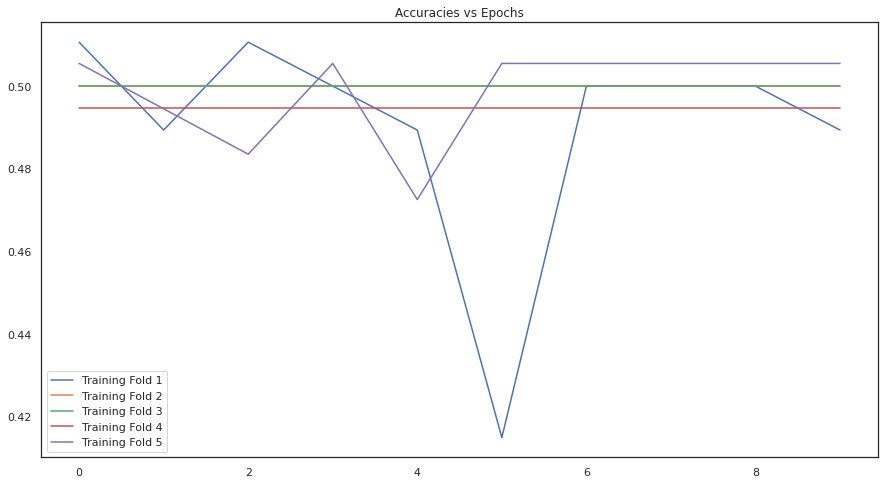

INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_ResNet50/assets


INFO:tensorflow:Assets written to: /home/jovyan/Data_MT/final_notebook/Cross_Val_Model/new_ResNet50/assets
/tmp/ipykernel_26192/2778687557.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


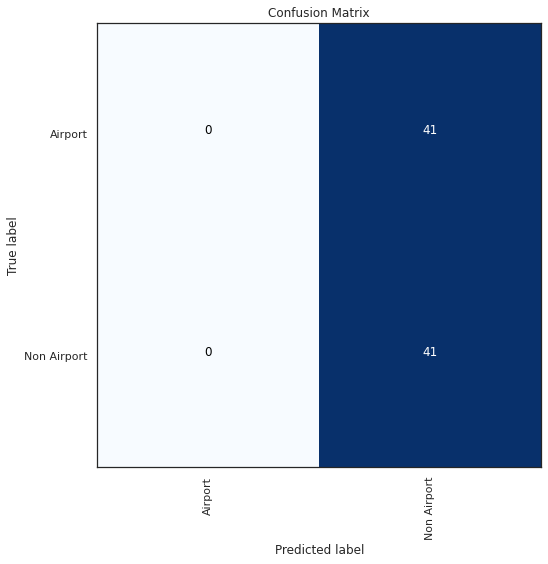

Accuracy in test set: 50.0% 


In [36]:
# Plot learning curves
plot_learning_curves(model_history_ResNet50)

# Save the trained model
Trained_model_ResNet50.save(outFldModels+'/new_ResNet50')

# Load the saved model
Final_model_ResNet50 = models.load_model(outFldModels+'/new_ResNet50')

# Calculate and plot confusion matrix
cm_ResNet50, y_pred_ResNet50 = Calculate_ConfMatrix(Final_model_ResNet50, test_generator)
plot_confusion_matrix(cm_ResNet50, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')
plt.show()

# Calculate accuracy on test set
accuracy_ResNet50 = accuracy_score(test_generator.classes, y_pred_ResNet50)
print("Accuracy in test set: %0.1f%% " % (accuracy_ResNet50 * 100))

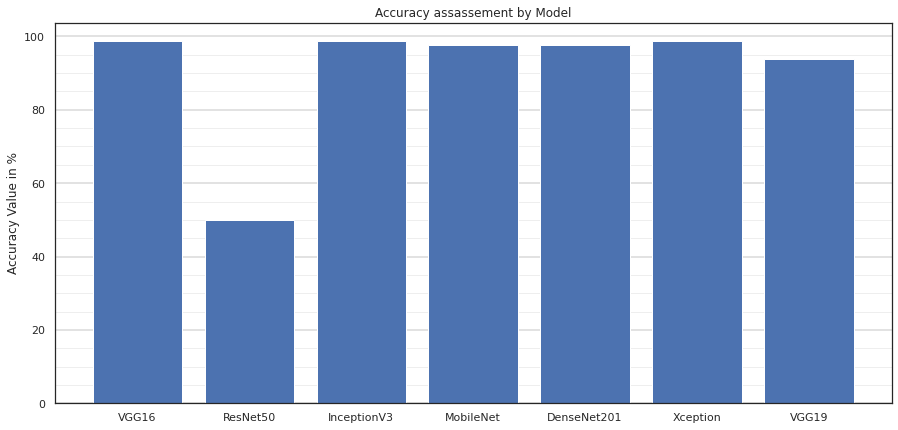

In [40]:
# Setting the size of the plot
plt.rcParams["figure.figsize"] = (15,7)

# Creating a new figure
fig, ax = plt.subplots()

# Defining the models and their corresponding accuracy values
Models = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNet','DenseNet201','Xception','VGG19']
Models_accuracy = [accuracy_VGG16*100, accuracy_ResNet50*100, accuracy_InceptionV3*100, accuracy_MobileNet*100,accuracy_DenseNet201*100, accuracy_Xception*100, accuracy_VGG19*100]

# Creating a bar plot of the models and their accuracy
ax.bar(Models, Models_accuracy, label=Models)

# Setting the y-label and title for the plot
ax.set_ylabel('Accuracy Value in %')
ax.set_title('Accuracy assassement by Model')

# Creating a grid for the y-axis
ax.grid(axis = 'y',which='major', color='#DDDDDD', linewidth=1.7)

# Creating a minor grid as well
ax.grid(axis = 'y',which='minor', color='#EEEEEE', linestyle='-', linewidth=1)

# Showing minor ticks and gridlines
ax.minorticks_on()

# Displaying the plot
plt.show()

In [38]:
# Creating the data as a list of lists
data =  [["VGG16", "%0.1f%% " % (accuracy_VGG16 * 100)], 
        ["ResNet50", "%0.1f%% " % (accuracy_ResNet50 * 100)],
        ["InceptionV3", "%0.1f%% " % (accuracy_InceptionV3 * 100)],
        ["MobileNet", "%0.1f%% " % (accuracy_MobileNet * 100)],
        ["DenseNet201","%0.1f%% " % (accuracy_DenseNet201 * 100)],
        ["Xception","%0.1f%% " % (accuracy_Xception * 100)],
        ["VGG19", "%0.1f%% " % (accuracy_VGG19 * 100)]]

# Defining the header names
col_names = ["Model Name", "Accuracy Value"]

# Displaying the table using the tabulate function
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒══════════════╤══════════════════╕
│ Model Name   │ Accuracy Value   │
╞══════════════╪══════════════════╡
│ VGG16        │ 98.8%            │
├──────────────┼──────────────────┤
│ ResNet50     │ 50.0%            │
├──────────────┼──────────────────┤
│ InceptionV3  │ 98.8%            │
├──────────────┼──────────────────┤
│ MobileNet    │ 97.6%            │
├──────────────┼──────────────────┤
│ DenseNet201  │ 97.6%            │
├──────────────┼──────────────────┤
│ Xception     │ 98.8%            │
├──────────────┼──────────────────┤
│ VGG19        │ 93.9%            │
╘══════════════╧══════════════════╛
